# Natural Language Processing Project
## NLP Course @ Politecnico di Milano 2024/2025 - Prof. Mark Carman
### Topic 8: Medical Question Answering
Dataset: 
* PubMedQA [link](https://huggingface.co/datasets/qiaojin/PubMedQA )

Reference paper:
* PubMedQA: A Dataset for Biomedical Research Question Answering [Link](https://arxiv.org/pdf/1909.06146)

## Group members:

* Ketrin Mehmeti
* Giulia Ghiazza
* Leonardo Giorgio Franco
* Edoardo Franco Mattei
* Alessandro Epifania

## Libraries and Dataset Loading

In [1]:
!pip install datasets
!pip install transformers
!pip install torch
!pip install wordcloud
!pip install mpl_toolkits
!pip install gensim
!pip install hdbscan

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits


In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


C:\Users\213053\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Loading the dataset: 

The object dataset is a DatasetDict, and in this case instead of different splits like "train", "validation", and "test" contains only the "train" section. 


In [3]:
# Load the labeled, unlabeled, and artificial subsets of PubMedQA
# The dataset is split into three subsets:

dataset_labeled = load_dataset("qiaojin/PubMedQA", 'pqa_labeled')               
dataset_unlabeled = load_dataset("qiaojin/PubMedQA", 'pqa_unlabeled')    
dataset_artificial = load_dataset('qiaojin/PubMedQA', 'pqa_artificial')  

In [4]:
print("Labeled dataset:", dataset_labeled)
print("Artificial dataset:", dataset_artificial)
print("Unlabeled dataset:", dataset_unlabeled)

# Notice that the feature final_decision is missing in the Unlabeled dataset, reflecting the fact 
# that these examples do not have a definitive yes/no/maybe label.

Labeled dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 1000
    })
})
Artificial dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 211269
    })
})
Unlabeled dataset: DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer'],
        num_rows: 61249
    })
})


In [5]:
print(dataset_labeled.keys())
print(dataset_artificial.keys())
print(dataset_unlabeled.keys())

dict_keys(['train'])
dict_keys(['train'])
dict_keys(['train'])


In [6]:
# Convert the datasets to pandas DataFrames for easier manipulation
df_labeled_original = pd.DataFrame(dataset_labeled['train'])
df_unlabeled_original = pd.DataFrame(dataset_unlabeled['train'])
df_artificial_original = pd.DataFrame(dataset_artificial['train'])

In [7]:
# Make a copy of the original datasets to work on
df_labeled = df_labeled_original.copy()
df_unlabeled = df_unlabeled_original.copy()
df_artificial = df_artificial_original.copy()

In [8]:
df_labeled.head()

,pubid,question,context,long_answer,final_decision
0,21645374,Do mitochondria play a role in remodelling lac...,{'contexts': ['Programmed cell death (PCD) is ...,Results depicted mitochondrial dynamics in viv...,yes
1,16418930,Landolt C and snellen e acuity: differences in...,{'contexts': ['Assessment of visual acuity dep...,"Using the charts described, there was only a s...",no
2,9488747,"Syncope during bathing in infants, a pediatric...",{'contexts': ['Apparent life-threatening event...,"""Aquagenic maladies"" could be a pediatric form...",yes
3,17208539,Are the long-term results of the transanal pul...,{'contexts': ['The transanal endorectal pull-t...,Our long-term study showed significantly bette...,no
4,10808977,Can tailored interventions increase mammograph...,{'contexts': ['Telephone counseling and tailor...,The effects of the intervention were most pron...,yes


In [9]:
df_unlabeled.head()

,pubid,question,context,long_answer
0,14499029,Is naturopathy as effective as conventional th...,{'contexts': ['Although the use of alternative...,Naturopathy appears to be an effective alterna...
1,14499049,Can randomised trials rely on existing electro...,"{'contexts': ['To estimate the feasibility, ut...",Routine data have the potential to support hea...
2,14499672,Is laparoscopic radical prostatectomy better t...,{'contexts': ['To compare morbidity in two gro...,The results of our non-randomized study show t...
3,14499773,Does bacterial gastroenteritis predispose peop...,{'contexts': ['Irritable bowel syndrome (IBS) ...,Symptoms consistent with IBS and functional di...
4,14499777,Is early colonoscopy after admission for acute...,{'contexts': ['Urgent colonoscopy has been pro...,No significant association is apparent between...


In [10]:
df_artificial.head()

,pubid,question,context,long_answer,final_decision
0,25429730,Are group 2 innate lymphoid cells ( ILC2s ) in...,{'contexts': ['Chronic rhinosinusitis (CRS) is...,"As ILC2s are elevated in patients with CRSwNP,...",yes
1,25433161,Does vagus nerve contribute to the development...,{'contexts': ['Phosphatidylethanolamine N-meth...,Neuronal signals via the hepatic vagus nerve c...,yes
2,25445714,Does psammaplin A induce Sirtuin 1-dependent a...,{'contexts': ['Psammaplin A (PsA) is a natural...,PsA significantly inhibited MCF-7/adr cells pr...,yes
3,25431941,Is methylation of the FGFR2 gene associated wi...,{'contexts': ['This study examined links betwe...,We identified a novel biologically plausible c...,yes
4,25432519,Do tumor-infiltrating immune cell profiles and...,{'contexts': ['Tumor microenvironment immunity...,Breast cancer immune cell subpopulation profil...,yes


# First step: Preliminary analysis
Briefly describe the data:
- What is the structure of the dataset? What type of task was the dataset collected for?
- What type of documents does it contain? How many are there? How long are they on average and
what is their distribution?
- How big is the vocabulary of the collection? How big is the vocabulary of a document on average?

Play around with documents using code from the early parts of the course. For example, you could:
- Cluster the documents, visualise the clusters and to try to understand what types of groups are
present.
- Index the documents so that you can perform keyword search over them.
- Train a Word2Vec embedding and investigate the properties of the resulting embedding.

## Dataset Description

In [11]:
# Check the data types of individual elements in each feature (question, context, long_answer)
# across the labeled, unlabeled, and artificial datasets. This is useful to verify that all elements 
# are strings before applying any text processing or tokenization functions, since functions from 
# libraries like Hugging Face's Transformers typically expect string inputs.

print(type(df_labeled['question'][0]))
print(type(df_labeled['context'][0]))
print(type(df_labeled['long_answer'][0]))
print(" ")

print(type(df_unlabeled['question'][0]))
print(type(df_unlabeled['context'][0]))
print(type(df_unlabeled['long_answer'][0]))
print(" ")

print(type(df_artificial['question'][0]))
print(type(df_artificial['context'][0]))
print(type(df_artificial['long_answer'][0]))

<class 'str'>
<class 'dict'>
<class 'str'>
 
<class 'str'>
<class 'dict'>
<class 'str'>
 
<class 'str'>
<class 'dict'>
<class 'str'>


### "Context" Analysis

In [12]:
# Each 'context' entry is a dictionary containing multiple keys.
# In the labeled dataset, each context includes:
# - 'contexts': a list of textual context passages
# - 'labels': a list of associated labels
# - 'meshes': a list of medical subject headings
# - 'reasoning_required_pred': a list indicating whether reasoning is required (only in labeled)
# - 'reasoning_free_pred': a list indicating whether the question is reasoning-free (only in labeled)
# 
# In contrast, the unlabeled and artificial datasets contain only:
# - 'contexts', 'labels', and 'meshes'
# 
# This structural difference is important when preprocessing the data, 
# since some fields (e.g., 'reasoning_required_pred') are not available across all datasets.


for key, value in df_labeled['context'][0].items():
    print(f"{key}: {type(value)}")

print(" ")

for key, value in df_unlabeled['context'][0].items():
    print(f"{key}: {type(value)}")

print(" ")

for key, value in df_artificial['context'][0].items():
    print(f"{key}: {type(value)}")

contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>
reasoning_required_pred: <class 'list'>
reasoning_free_pred: <class 'list'>
 
contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>
 
contexts: <class 'list'>
labels: <class 'list'>
meshes: <class 'list'>


In [13]:
print(type(df_artificial['context'].iloc[0]))

<class 'dict'>


In [14]:
print(df_artificial['context'].iloc[0])

{'contexts': ['Chronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated.', 'The aim of this study was to identify ILC2s in sinus mucosa in patients with CRS and controls and compare ILC2s across characteristics of disease.', 'A cross-sectional study of patients with CRS undergoing endoscopic sinus surgery was conducted. Sinus mucosal biopsies were obtained during surgery and control tissue from patients undergoing pituitary tumour resection through transphenoidal approach. ILC2s were identified as CD45(+) Lin(-) CD127(+) CD4(-) CD8(-) CRTH2(CD294)(+) CD161(+) cells in single cell suspensions through flow cytometry. ILC2 frequencies, measured as a percentage of CD45(+) cells, were compared across CRS phenotype, endotype

In [ ]:
for df in [df_artificial, df_labeled, df_unlabeled]:
    df['context'] = df['context'].apply(lambda x: ' '.join(x.get('contexts', [])))

# I select the context key from the dictionary where the abstract is stored, 
# and I use join because inside it there was a list with each sentence as a string. 
# This way, I get a single document within the context column.

In [16]:
df_unlabeled.head()

,pubid,question,context,long_answer
0,14499029,Is naturopathy as effective as conventional th...,Although the use of alternative medicine in th...,Naturopathy appears to be an effective alterna...
1,14499049,Can randomised trials rely on existing electro...,"To estimate the feasibility, utility and resou...",Routine data have the potential to support hea...
2,14499672,Is laparoscopic radical prostatectomy better t...,To compare morbidity in two groups of patients...,The results of our non-randomized study show t...
3,14499773,Does bacterial gastroenteritis predispose peop...,Irritable bowel syndrome (IBS) might develop a...,Symptoms consistent with IBS and functional di...
4,14499777,Is early colonoscopy after admission for acute...,Urgent colonoscopy has been proposed for the d...,No significant association is apparent between...


We then start to calculate various parameters regarding the the "contexts" list.

In [17]:
# AVERAGE LENGTH OF "CONTEXTS"

# Here we compute the average abstract length in terms of number of words, rather than number of segments.
# It's useful to understand how verbose or detailed the contexts are in natural language.

context_word_lengths_L = df_labeled['context'].apply(lambda x: len(x.split()))
print("Average number of words in abstract in the labeled dataset:", context_word_lengths_L.mean())
print("Standard deviation of words in abstract in the labeled dataset:", context_word_lengths_L.std())
print(" ")

context_word_lengths_U = df_unlabeled['context'].apply(lambda x: len(x.split()))
print("Average number of words in abstract in the unlabeled dataset:", context_word_lengths_U.mean())
print("Standard deviation of words in abstract in the unlabeled dataset:", context_word_lengths_U.std())
print(" ")

context_word_lengths_A = df_artificial['context'].apply(lambda x: len(x.split()))
print("Average number of words in abstract in the artificial dataset:", context_word_lengths_A.mean())
print("Standard deviation of words in abstract in the artificial dataset:", context_word_lengths_A.std())


Average number of words in abstract in the labeled dataset: 200.207
Standard deviation of words in abstract in the labeled dataset: 51.84642903038938
 
Average number of words in abstract in the unlabeled dataset: 198.7389018596222
Standard deviation of words in abstract in the unlabeled dataset: 56.65423030078211
 
Average number of words in abstract in the artificial dataset: 200.51420700623376
Standard deviation of words in abstract in the artificial dataset: 50.70859241655663


The average number of words in the abstract ('context') is very similar across the labeled, unlabeled, and artificial datasets, with means around 200 words. This consistency suggests that the datasets are well-aligned in terms of content length. 
Additionally, the standard deviations are comparable, indicating a similar spread and variability in abstract lengths.
These observations support the assumption that the datasets are structurally balanced and comparable for downstream tasks.

### "Question" Analysis

In [18]:
question_word_lengths_L = df_labeled['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the labeled dataset:", question_word_lengths_L.mean())
print("Standard deviation of words in question in the labeled dataset:", question_word_lengths_L.std())
print(" ")

question_word_lengths_U = df_unlabeled['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the unlabeled dataset:", question_word_lengths_U.mean())
print("Standard deviation of words in question in the unlabeled dataset:", question_word_lengths_U.std())
print(" ")

question_word_lengths_A = df_artificial['question'].apply(lambda x: len(x.split()))
print("Average number of words in question in the artificial dataset:", question_word_lengths_A.mean())
print("Standard deviation of words in question in the artificial dataset:", question_word_lengths_A.std())

Average number of words in question in the labeled dataset: 12.913
Standard deviation of words in question in the labeled dataset: 4.100517680152744
 
Average number of words in question in the unlabeled dataset: 13.34506685823442
Standard deviation of words in question in the unlabeled dataset: 4.567043839545208
 
Average number of words in question in the artificial dataset: 15.344096862294043
Standard deviation of words in question in the artificial dataset: 3.898447348860483


The average number of words in the 'question' field is slightly higher in the artificial dataset (~15.3 words) compared to the labeled (~12.9) and unlabeled (~13.3) datasets. Despite this difference, the standard deviations remain fairly close, indicating that the overall variability is consistent. This suggests that while artificial questions tend to be a bit longer, the distribution of their lengths is not drastically different, maintaining a reasonable alignment across datasets.

### "Long Answer" Analysis

In [19]:
long_answ_lengths_L = df_labeled['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the labeled dataset:", long_answ_lengths_L.mean())
print("Standard deviation of long_answer in the labeled dataset:", long_answ_lengths_L.std())
print(" ")

long_answ_lengths_U = df_unlabeled['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the unlabeled dataset:", long_answ_lengths_U.mean())
print("Standard deviation of long_answer in the unlabeled dataset:", long_answ_lengths_U.std())
print(" ")

long_answ_lengths_A = df_artificial['long_answer'].apply(lambda x: len(x.split()))
print("Average number of words in long_answer in the artificial dataset:", long_answ_lengths_A.mean())
print("Standard deviation of long_answer in the artificial dataset:", long_answ_lengths_A.std())

Average number of words in long_answer in the labeled dataset: 39.66
Standard deviation of long_answer in the labeled dataset: 17.209432430053138
 
Average number of words in long_answer in the unlabeled dataset: 42.02336364675342
Standard deviation of long_answer in the unlabeled dataset: 19.817240489404714
 
Average number of words in long_answer in the artificial dataset: 37.593660215175916
Standard deviation of long_answer in the artificial dataset: 18.49701353631026


The average number of words in the 'long_answer' field is relatively similar across the three datasets, ranging from approximately 37.6 to 42.0 words. 
The standard deviations are also comparable, suggesting that the variability in long answer lengths is consistent. Overall, there are no significant discrepancies in length distribution.

### "Final Decision" Analysis

In [20]:
# Count of 'final_decision' labels in Labeled and Artificial datasets

print(f"Occurrences of 'yes' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['yes']}")
print(f"Occurrences of 'no' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['no']}")
print(f"Occurrences of 'maybe' as the final decision in the Labeled dataset: {df_labeled['final_decision'].value_counts()['maybe']}")
print(" ")

print(f"Occurrences of 'yes' as the final decision in the Artificial dataset: {df_artificial['final_decision'].value_counts()['yes']}")
print(f"Occurrences of 'no' as the final decision in the Artificial dataset: {df_artificial['final_decision'].value_counts()['no']}")

Occurrences of 'yes' as the final decision in the Labeled dataset: 552
Occurrences of 'no' as the final decision in the Labeled dataset: 338
Occurrences of 'maybe' as the final decision in the Labeled dataset: 110
 
Occurrences of 'yes' as the final decision in the Artificial dataset: 196144
Occurrences of 'no' as the final decision in the Artificial dataset: 15125


The number of 'no' in the artificial dataset appears to be much smaller that the number of 'yes', indicating an unbalanced dataset.

We can visualize the difference between the two dataset by plotting the percentage distribution of final decision labels ('yes', 'no', 'maybe') for both the labeled and artificial datasets using side-by-side bar charts.


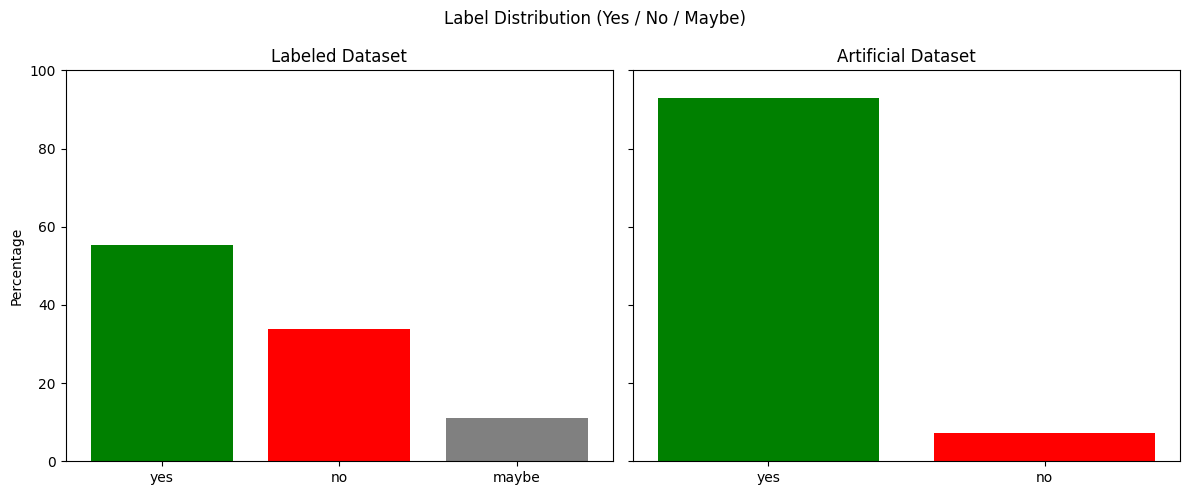

In [21]:
# Create subplots with shared y-axis to ensure the same scale across both bar plots.
# This makes it easier to visually compare the distribution of 'yes', 'no', and 'maybe' labels
# between the labeled and artificial datasets.

# Count label frequencies
labeled_counts = df_labeled['final_decision'].value_counts(normalize=True) * 100  
artificial_counts = df_artificial['final_decision'].value_counts(normalize=True) * 100

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot labeled dataset
axes[0].bar(labeled_counts.index, labeled_counts.values, color=['green', 'red', 'gray'])
axes[0].set_title("Labeled Dataset")
axes[0].set_ylabel("Percentage")
axes[0].set_ylim(0, 100)

# Plot artificial dataset
axes[1].bar(artificial_counts.index, artificial_counts.values, color=['green', 'red', 'gray'])
axes[1].set_title("Artificial Dataset")
axes[1].set_ylim(0, 100)

plt.suptitle("Label Distribution (Yes / No / Maybe)")
plt.tight_layout()
plt.show()


### Vocabulary Analysis

The aim of this section is to build and analyse a preliminary vocabulary (before preprocessing) for each dataset. <br>
The analysis will be repeated after the lemmization to compare the results. <br>
We start by building a function to compute the vocabulary. 

In [40]:
# Define a function to build a vocabulary counter from a list of texts:
# it lowercases the text, filters out stopwords and non-alphabetic tokens,
# and counts the frequency of each remaining word.

nltk.download('stopwords')
nltk.download('punkt')

# Stopword List
with open("clinical-stopwords-analysis.txt", "r", encoding="utf-8") as f:
    stop_words = set(line.strip().lower() for line in f if line.strip())

def get_vocab(texts):
    vocab_counter = Counter()
    for text in texts:
        if isinstance(text, str):
            words = text.lower().split()
            filtered_words = [w for w in words if w.isalpha() and w not in stop_words]
            vocab_counter.update(filtered_words)
    return vocab_counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Labeled Vocabulary

In [26]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Labeled dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_L = get_vocab(df_labeled['question'])
context_vocab_L = get_vocab(df_labeled['context'])
long_answer_vocab_L = get_vocab(df_labeled['long_answer'])

print("Vocabulary size in questions:", len(question_vocab_L))
print("Top 10 question words:", question_vocab_L.most_common(10))
print(" ")

print("Vocabulary size in context:", len(context_vocab_L))
print("Top 10 context words:", context_vocab_L.most_common(10))
print(" ")

print("Vocabulary size in long_answer:", len(long_answer_vocab_L))
print("Top 10 long_answer words:", long_answer_vocab_L.most_common(10))

Vocabulary size in questions: 2951
Top 10 question words: [('patients', 107), ('predict', 54), ('risk', 53), ('affect', 42), ('cancer', 40), ('care', 38), ('treatment', 36), ('improve', 33), ('influence', 32), ('breast', 29)]
 
Vocabulary size in context: 10365
Top 10 context words: [('patients', 2044), ('study', 736), ('group', 555), ('compared', 423), ('significantly', 394), ('significant', 383), ('mean', 326), ('data', 320), ('treatment', 313), ('risk', 302)]
 
Vocabulary size in long_answer: 5287
Top 10 long_answer words: [('patients', 293), ('risk', 135), ('study', 121), ('results', 120), ('associated', 109), ('treatment', 87), ('significant', 80), ('care', 70), ('data', 70), ('significantly', 67)]


### Unlabeled Vocabulary

In [28]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Unlabeled dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_U = get_vocab(df_unlabeled['question'])
context_vocab_U = get_vocab(df_unlabeled['context'])
long_answer_vocab_U = get_vocab(df_unlabeled['long_answer'])

print("Vocabulary size in questions:", len(question_vocab_U))
print("Top 10 question words:", question_vocab_U.most_common(10))
print(" ")

print("Vocabulary size in context:", len(context_vocab_U))
print("Top 10 context words:", context_vocab_U.most_common(10))
print(" ")

print("Vocabulary size in long_answer:", len(long_answer_vocab_U))
print("Top 10 long_answer words:", long_answer_vocab_U.most_common(10))

Vocabulary size in questions: 25135
Top 10 question words: [('patients', 6019), ('risk', 3126), ('treatment', 2193), ('cancer', 2157), ('predict', 2031), ('affect', 1987), ('associated', 1864), ('health', 1827), ('improve', 1743), ('care', 1679)]
 
Vocabulary size in context: 71652
Top 10 context words: [('patients', 124962), ('study', 41674), ('group', 35371), ('compared', 25634), ('significant', 23029), ('significantly', 21726), ('risk', 19519), ('mean', 19366), ('associated', 19103), ('data', 18552)]
 
Vocabulary size in long_answer: 41573
Top 10 long_answer words: [('patients', 20522), ('risk', 8286), ('study', 7202), ('results', 7165), ('associated', 6965), ('treatment', 5535), ('significant', 4439), ('health', 4336), ('findings', 4276), ('high', 4089)]


### Artificial Vocabulary

In [30]:
# Compute the vocabulary (filtered and lowercased, excluding stopwords) for each feature in the Artificial dataset:
# - questions
# - context (joined list of strings)
# - long answers
# Then print the 10 most common words for each, along with the total vocabulary size per feature.

question_vocab_A = get_vocab(df_artificial['question'])
context_vocab_A = get_vocab(df_artificial['context'])
long_answer_vocab_A = get_vocab(df_artificial['long_answer'])

print("Vocabulary size in questions:", len(question_vocab_A))
print("Top 10 question words:", question_vocab_A.most_common(10))
print(" ")

print("Vocabulary size in context:", len(context_vocab_A))
print("Top 10 context words:", context_vocab_A.most_common(10))
print(" ")

print("Vocabulary size in long_answer:", len(long_answer_vocab_A))
print("Top 10 long_answer words:", long_answer_vocab_A.most_common(10))

Vocabulary size in questions: 51549
Top 10 question words: [('associated', 29304), ('patients', 20726), ('cell', 12270), ('human', 12033), ('expression', 10917), ('cells', 10531), ('cancer', 9816), ('predict', 8543), ('risk', 8408), ('factor', 7703)]
 
Vocabulary size in context: 134019
Top 10 context words: [('patients', 272161), ('expression', 119844), ('study', 109274), ('significantly', 107742), ('cells', 105349), ('cell', 95718), ('levels', 91193), ('compared', 90459), ('group', 88096), ('increased', 87261)]
 
Vocabulary size in long_answer: 73057
Top 10 long_answer words: [('patients', 43975), ('results', 33230), ('associated', 32046), ('study', 21367), ('risk', 20590), ('expression', 18244), ('increased', 18079), ('data', 17988), ('findings', 17728), ('treatment', 16905)]


### Complete Vocabulary

In [31]:
# Now we compute the total vocabulary across all three datasets for the 'context' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_context = (
    context_vocab_L + context_vocab_U + context_vocab_A
)

# Print the 20 most common words in the combined vocabulary in the context feature, along with the total vocabulary size.
print("Total vocabulary size across all datasets in the context feature:", len(total_vocab_context))
print("Top 20 most common words in the entire corpus of contexts:", total_vocab_context.most_common(20))

Total vocabulary size across all datasets in the context feature: 153119
Top 20 most common words in the entire corpus of contexts: [('patients', 399167), ('study', 151684), ('significantly', 129862), ('group', 124022), ('expression', 122463), ('compared', 116516), ('cells', 108365), ('associated', 105714), ('levels', 102699), ('cell', 100220), ('increased', 99397), ('significant', 87683), ('higher', 76351), ('treatment', 74767), ('risk', 71943), ('analysis', 66401), ('control', 63229), ('effect', 61011), ('blood', 60709), ('protein', 60420)]


In [32]:
# Now we compute the total vocabulary across all three datasets for the 'question' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_question = (
    question_vocab_L + question_vocab_U + question_vocab_A
)

# Print the 20 most common words in the combined vocabulary of the question feature, along with the total vocabulary size.
print("Total vocabulary size across all datasets in the question feature:", len(total_vocab_question))
print("Top 20 most common words in the entire corpus of questions:", total_vocab_question.most_common(20))

Total vocabulary size across all datasets in the question feature: 57221
Top 20 most common words in the entire corpus of questions: [('associated', 31192), ('patients', 26852), ('cell', 13270), ('human', 12553), ('cancer', 12013), ('risk', 11587), ('expression', 11201), ('cells', 10773), ('predict', 10628), ('factor', 8845), ('improve', 8724), ('disease', 7812), ('treatment', 7611), ('acute', 7538), ('gene', 7436), ('increased', 7065), ('protein', 6831), ('chronic', 6649), ('growth', 6574), ('levels', 6505)]


In [33]:
# Now we compute the total vocabulary across all three datasets for the 'long_answer' field.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab_long_answer = (
    long_answer_vocab_L + long_answer_vocab_U + long_answer_vocab_A
)

# Print the 20 most common words in the combined vocabulary in the long_answer feature, along with the total vocabulary size.
print("Total vocabulary size across all datasets in the long_answer feature:", len(total_vocab_long_answer))
print("Top 20 most common words in the entire corpus of long answers:", total_vocab_long_answer.most_common(20))

Total vocabulary size across all datasets in the long_answer feature: 83675
Top 20 most common words in the entire corpus of long answers: [('patients', 64790), ('results', 40515), ('associated', 39120), ('risk', 29011), ('study', 28690), ('treatment', 22527), ('increased', 22177), ('findings', 22064), ('data', 21750), ('expression', 18819), ('role', 18251), ('levels', 15663), ('high', 15270), ('cell', 15262), ('effect', 14883), ('cells', 14822), ('important', 14590), ('potential', 14083), ('cancer', 13540), ('significant', 13454)]


In [34]:
# Now we compute the total vocabulary across all three datasets for all features combined.
# This is done by combining the vocabularies from the labeled, unlabeled, and artificial datasets.

total_vocab = (
    question_vocab_L + context_vocab_L + long_answer_vocab_L +
    question_vocab_U + context_vocab_U + long_answer_vocab_U +
    question_vocab_A + context_vocab_A + long_answer_vocab_A
)

# Print the 20 most common words in the combined vocabulary across all features, along with the total vocabulary size.
print("Total vocabulary size across all datasets:", len(total_vocab))
print("Top 20 most common words in the entire corpus:", total_vocab.most_common(20))

Total vocabulary size across all datasets: 163230
Top 20 most common words in the entire corpus: [('patients', 490809), ('study', 183171), ('associated', 176026), ('expression', 152483), ('significantly', 144070), ('cells', 133960), ('cell', 128752), ('increased', 128639), ('group', 128636), ('compared', 127461), ('levels', 124867), ('risk', 112541), ('treatment', 104905), ('significant', 102088), ('higher', 90998), ('cancer', 85056), ('effect', 79273), ('disease', 75096), ('analysis', 73806), ('data', 73773)]


### Word Clouds

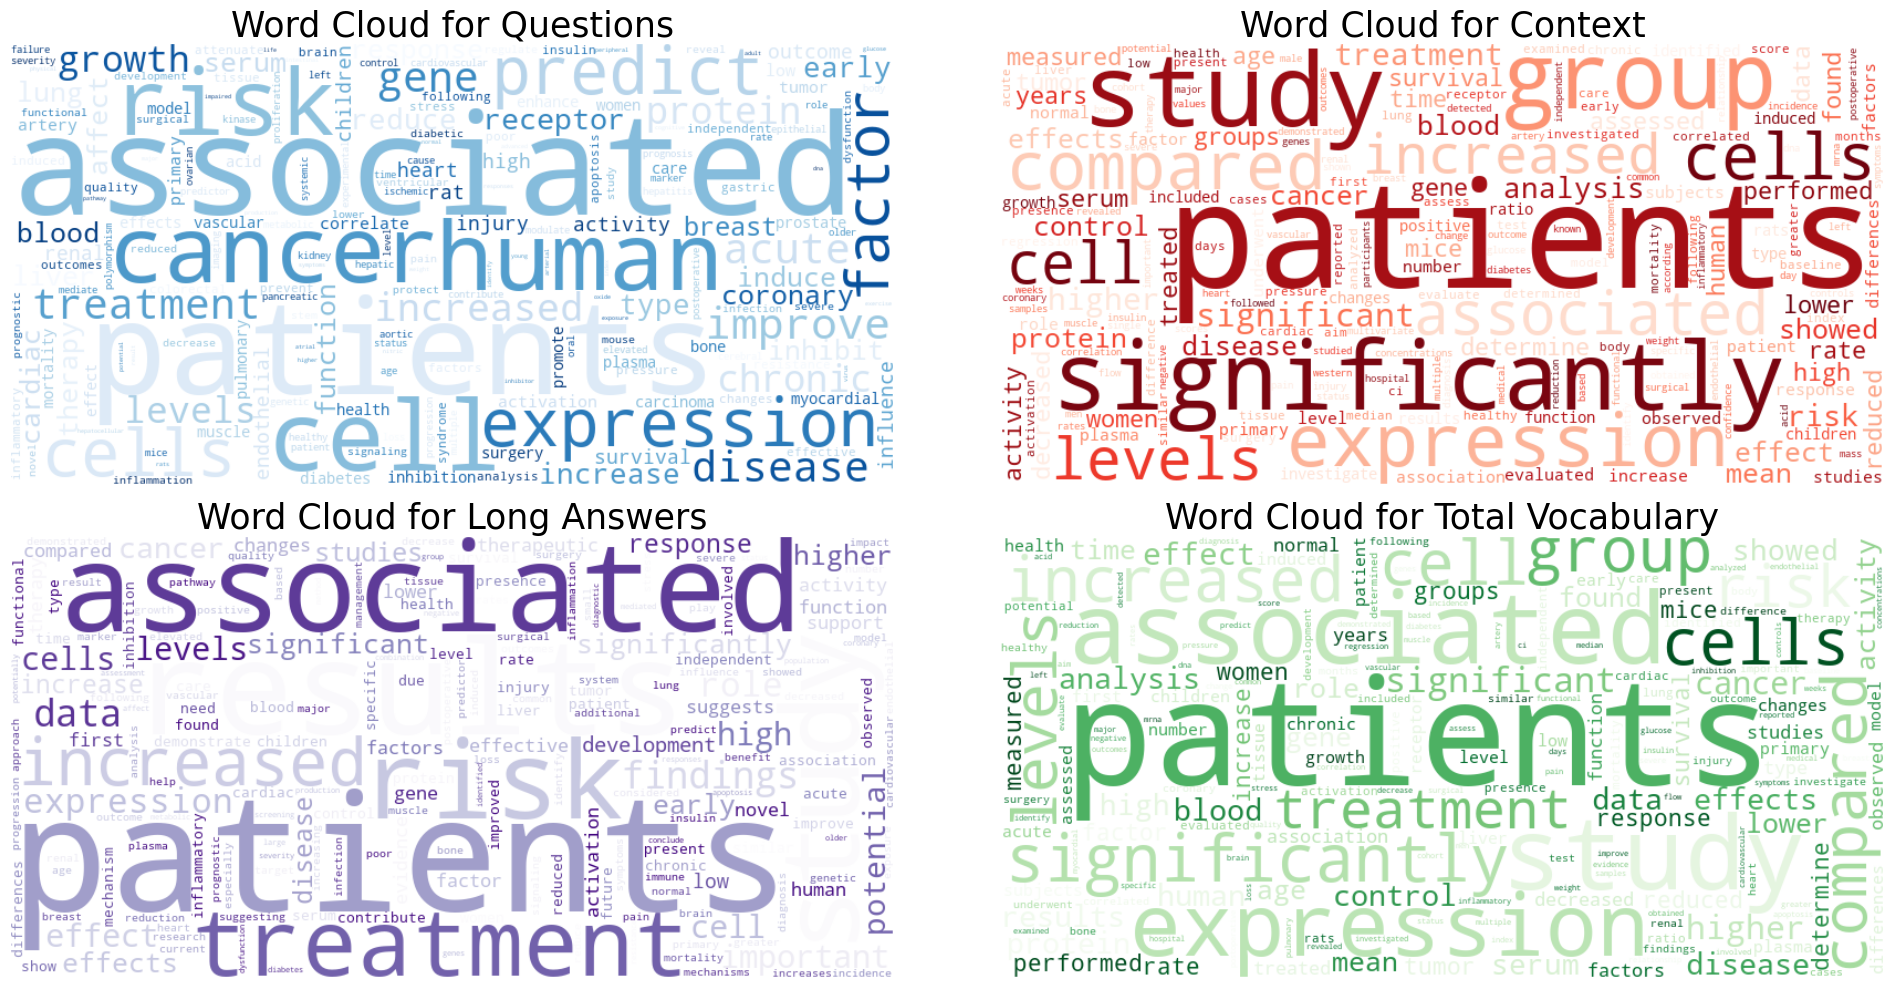

In [35]:
# Now we generate word clouds for the vocabularies of the three features: 'question', 'context', and 'long_answer' and for the total vocabulary across all datasets.
# A word cloud is a visual representation of word frequency, where more frequent words appear larger.
# The function 'generate_wordcloud' takes a vocabulary counter (a dictionary of word frequencies) and a title for the plot.

vocabs = [
    (total_vocab_question, "Questions", "Blues"),
    (total_vocab_context, "Context", "Reds"),
    (total_vocab_long_answer, "Long Answers", "Purples"),
    (total_vocab, "Total Vocabulary", "Greens")  # Aggiungi questo solo se hai total_vocab_total
]

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for ax, (vocab, title, colormap) in zip(axes.flat, vocabs):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate_from_frequencies(vocab)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Word Cloud for {title}", fontsize=25)
    ax.axis('off')

plt.tight_layout()
plt.show()


### Indexing documents

In [6]:
!pip install rank_bm25

In [11]:

df_labeled['document'] = (
    "Question: " + df_labeled['question'] + "\n" +
    "Context: " + df_labeled['context'] + "\n" +
    "Answer: " + df_labeled['long_answer'] +
    ("\nLabel: " + df_labeled['final_decision'] if 'final_decision' in df_labeled.columns else "")
)



In [18]:

from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize

# Prepara i documenti
tokenized_docs = [word_tokenize(doc.lower()) for doc in df_labeled['document']]
bm25 = BM25Okapi(tokenized_docs)

# Query esempio
query = " lung tumor"
tokenized_query = word_tokenize(query.lower())
scores = bm25.get_scores(tokenized_query)

# Top 5 risultati
top_n = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:5]
for i, score in top_n:
    print(f"Score: {score:.2f}")
    print(df_labeled.iloc[i]['document'])
    print("—" * 50)

Score: 12.07
Question: Can serum be used for analyzing the EGFR mutation status in patients with advanced non-small cell lung cancer?
Context: Epidermal growth factor receptor (EGFR) mutations as prognostic or predictive marker in patients with non-small cell lung cancer (NSCLC) have been used widely. However, it may be difficult to get tumor tissue for analyzing the status of EGFR mutation status in large proportion of patients with advanced disease. We obtained pairs of tumor and serum samples from 57 patients with advanced NSCLC, between March 2006 and January 2009. EGFR mutation status from tumor samples was analyzed by genomic polymerase chain reaction and direct sequence and EGFR mutation status from serum samples was determined by the peptide nucleic acid locked nucleic acid polymerase chain reaction clamp. EGFR mutations were detected in the serum samples of 11 patients and in the tumor samples of 12 patients. EGFR mutation status in the serum and tumor samples was consistent i

In [19]:
df_artificial['document'] = (
    "Question: " + df_artificial['question'] + "\n" +
    "Context: " + df_artificial['context'] + "\n" +
    "Answer: " + df_artificial['long_answer'] +
    ("\nLabel: " + df_artificial['final_decision'] if 'final_decision' in df_artificial.columns else "")
)


In [20]:
# Prepara i documenti
tokenized_docs = [word_tokenize(doc.lower()) for doc in df_artificial['document']]
bm25 = BM25Okapi(tokenized_docs)

# Query esempio
query = " adolescence anxiety"
tokenized_query = word_tokenize(query.lower())
scores = bm25.get_scores(tokenized_query)

# Top 5 risultati
top_n = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:5]
for i, score in top_n:
    print(f"Score: {score:.2f}")
    print(df_artificial.iloc[i]['document'])
    print("—" * 50)

KeyboardInterrupt: 

#### Word2Vec embedding and his properties

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

nltk.download('punkt')

# Unisci i testi
texts = df_artificial['question'].fillna('') + " " + df_artificial['context'].fillna('') + " " + df_labeled['long_answer'].fillna('')

# Tokenizza ogni documento
tokenized_texts = [word_tokenize(doc.lower()) for doc in texts]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
model_W2V = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,   # dimensione del vettore
    window=5,          # contesto sinistro e destro
    min_count=2,       # ignora parole rare
    workers=4,         # parallelismo
    sg=1               # 1 = skip-gram, 0 = CBOW
)

In [25]:
model_W2V.wv.most_similar("cancer", topn=10)

[('breast', 0.826148271560669),
 ('advanced', 0.8244144320487976),
 ('metastatic', 0.8132159113883972),
 ('lung', 0.8131628632545471),
 ('non-small', 0.8010520935058594),
 ('colorectal', 0.8006892800331116),
 ('rectal', 0.7940624356269836),
 ('prostate', 0.7936402559280396),
 ('ovarian', 0.7929231524467468),
 ('localized', 0.7913591265678406)]

In [26]:
model_W2V.wv.similarity("tumor", "cancer")

0.56176925

In [27]:
model_W2V.wv.most_similar(positive=["cancer", "treatment"], negative=["disease"])

[('chemotherapy', 0.6133092045783997),
 ('radiotherapy', 0.6090891361236572),
 ('surgery', 0.5971412658691406),
 ('resection', 0.5952693223953247),
 ('prostate', 0.5872091054916382),
 ('therapy', 0.5808526277542114),
 ('laparoscopic', 0.5775279998779297),
 ('radiation', 0.569858729839325),
 ('diagnosis', 0.5627505779266357),
 ('prostatectomy', 0.5621044039726257)]

## Classification



<h5> 
Prima di tutto sia il dataset artificial che quello labeled sono stati preprocessati:
 <ul>
 <li>Rimozione stopword 
 <li>lowercase
 <li>lemmmizzazione
 <li>Rimozione carartteri speciali e punteggiatura
 </ul>
 
 Successivamente i testi presenti nelle feature Question e long answer del dataset artificial sono stati usati per trainareo ad un modello word2vec, grazie al quale poi sono state create le rappresentazioni embeddind di tutti i testi contenuti nei suddetti attributi sia per il dataset artificial ceh per quello labeled.

 Sono stati poi presi in esame 3 classificatori SVM, Logistic regressio e Random Forest; Ogni classificatore è stato trainato con gli embedding del dataset artificial e testato sul datatset labeled. 
 Per valutare il peso delle diverse features nella classificazione è stata performata una classificazione usando come features solo gli emebedding contenuti in questions, una considerando sono quelli contenuti in Long_answer e infine una considerando come features entrambi i vettori embedding sia della question che della long answer
</h5>

In [36]:
# Sample 10k examples from each class ("yes" and "no") in the artificial dataset to balance the class distribution
no_sample = df_artificial[df_artificial['final_decision'] == 'no'].sample(n=10000, random_state=42)
yes_sample = df_artificial[df_artificial['final_decision'] == 'yes'].sample(n=10000, random_state=42)

# Combine and shuffle the two samples to form a balanced artificial dataset
df_artificial_sampled = pd.concat([yes_sample, no_sample]).sample(frac=1, random_state=42).reset_index(drop=True)


# Drop examples in the labeled dataset where the label is "maybe"
# Since "maybe" cannot be predicted by a binary classifier trained on "yes"/"no"
df_labeled_clean = df_labeled[df_labeled['final_decision'].isin(['yes', 'no'])].copy()


In [37]:
# Uniamo i testi presenti in question, context e long answer nella colonna text
for df in [df_artificial_sampled, df_labeled_clean, df_unlabeled]:
    df["text"] = (
        "question: " + df["question"].fillna("") +
        " context: " + df["context"].fillna("") 
       # " long_answer: " + df["long_answer"].fillna("")
    )

In [41]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w.isalpha()]                # solo parole (niente punteggiatura/numero)
    tokens = [w for w in tokens if w not in stop_words]        # rimuovi stopwords (che ora sono prese da clinical-stopwords-analysis.txt)
    tokens = [lemmatizer.lemmatize(w) for w in tokens]         # lemmatizzazione
    return tokens

# Applica il preprocessing
df_artificial_sampled_prep = df_artificial_sampled.copy()
df_labeled_clean_prep = df_labeled_clean.copy()
df_unlabeled_prep= df_unlabeled.copy()

for df in [df_artificial_sampled_prep, df_labeled_clean_prep, df_unlabeled_prep]:
    for col in ['text', 'long_answer']:
        df[col] = df[col].apply(preprocess)

# A questo punto ho applicato il preprocessing a tutte le colonne dei 3 dataet


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\213053\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
df_artificial_sampled_prep.head()

,pubid,question,context,long_answer,final_decision,text
0,11289484,Does blood pressure rise before the onset of m...,To examine whether a rise in blood pressure co...,"[rise, systemic, bp, detected, first, appearan...",no,"[question, blood, pressure, rise, onset, micro..."
1,16969853,Does systemic immunosuppressive therapy inhibi...,Cyclosporine is used routinely for prophylaxis...,"[renal, transplant, patient, receiving, combin...",yes,"[question, systemic, immunosuppressive, therap..."
2,19026002,Does bile duct proliferation in Jag1/fringe he...,Alagille syndrome (AGS) is a heterogeneous dev...,"[mouse, heterozygous, mutation, fringe, gene, ...",yes,"[question, bile, duct, proliferation, heterozy..."
3,15525465,Does capsaicin facilitate carotid sinus barore...,To study the effect of capsaicin on carotid si...,"[capsaicin, exerts, facilitatory, role, isolat...",yes,"[question, capsaicin, facilitate, carotid, sin..."
4,17601704,Is the catechol O-methyltransferase Val158Met ...,A valine/methionine polymorphism of the catech...,"[based, result, sample, catechol, polymorphism...",no,"[question, catechol, polymorphism, associated,..."


In [ ]:
# # Cambiamo yes e no con 0 e 1 perche migliora la performance del classificatore
# df_artificial_sampled["final_decision"] = df_artificial_sampled["final_decision"].map({"no": 0, "yes": 1})
# df_labeled_clean["final_decision"] = df_labeled_clean["final_decision"].map({"no": 0, "yes": 1})

# df_artificial_sampled_prep["final_decision"] = df_artificial_sampled_prep["final_decision"].map({"no": 0, "yes": 1})
# df_labeled_clean_prep["final_decision"] = df_labeled_clean_prep["final_decision"].map({"no": 0, "yes": 1})

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model, param_grid, scoring='accuracy', cv=5):
    """
    Esegue GridSearchCV su un classificatore sklearn usando feature matrix e label separati.

    Args:
        X_train (array or sparse matrix): matrice delle feature di training
        y_train (array or Series): target di training
        X_test (array or sparse matrix): matrice delle feature di test
        y_test (array or Series): target di test
        model: classificatore sklearn (es. RandomForestClassifier())
        param_grid (dict): dizionario con iperparametri per la grid search
        scoring (str): metrica di scoring per la grid search (default: 'accuracy')
        cv (int): numero di fold nella cross-validation (default: 5)
    """
    print(" Esecuzione GridSearchCV...")
    grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print("\n Migliori parametri trovati:")
    print(grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("\n Matrice di Confusione:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [45]:

# Naive Bayes
nb = MultinomialNB()
nb_param = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 100]
}


# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [
    {
        "solver": ["liblinear"], 
        "penalty": ["l1", "l2"],
        "C": [0.01, 0.1, 1, 10]
    },
    {
        "solver": ["lbfgs", "sag", "saga"], 
        "penalty": ["l2"],
        "C": [0.01, 0.1, 1]
    }
]


# SVC
svc = SVC()
svc_param = {
    "kernel": ["rbf"],
    "C": [0.1, 1, 10]
}


# Decision Tree
dtree = DecisionTreeClassifier()
dtree_param = {
    "criterion": ["gini", "entropy"], 
    "max_features": [None, "sqrt", "log2"]
}


# Random Forest
rf = RandomForestClassifier()
rf_param = {
    "criterion": ["gini", "entropy"]
}


# KNeighbors
kn = KNeighborsClassifier()
kn_param = {
    "n_neighbors": [1, 3, 5],
    "weights": ["uniform", "distance"]
}


# XGBoost (Gradient Boosting con loss="exponential")
xgb = GradientBoostingClassifier(loss="exponential")
xgb_param = {
    "n_estimators": [50, 200],
    "criterion": ["friedman_mse", "squared_error"]
}

### Bag of Word representation

In [46]:
!pip install pandas scikit-learn xgboost
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

#### Question + Context

In [47]:
# Uniamo i testi presenti in question, context e long answer nella colonna text
for df in [df_artificial_sampled, df_labeled_clean, df_unlabeled]:
    df["text"] = (
        "question: " + df["question"].fillna("") +
        " context: " + df["context"].fillna("") 
       # " long_answer: " + df["long_answer"].fillna("")
    )

In [48]:
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1,2))
Artificial_BoW = vectorizer.fit_transform(df_artificial_sampled["text"])
Labeled_BoW = vectorizer.transform(df_labeled_clean["text"])

 Esecuzione GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\213053\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(



 Migliori parametri trovati:
{'alpha': 0.001}

 Matrice di Confusione:


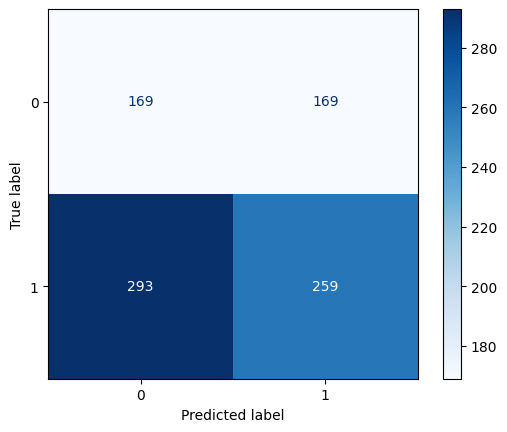


 Classification Report:
              precision    recall  f1-score   support

          no       0.37      0.50      0.42       338
         yes       0.61      0.47      0.53       552

    accuracy                           0.48       890
   macro avg       0.49      0.48      0.48       890
weighted avg       0.51      0.48      0.49       890



In [49]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], nb, nb_param, scoring='f1', cv=5)

 Esecuzione GridSearchCV...
Fitting 5 folds for each of 17 candidates, totalling 85 fits


C:\Users\213053\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



 Migliori parametri trovati:
{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

 Matrice di Confusione:


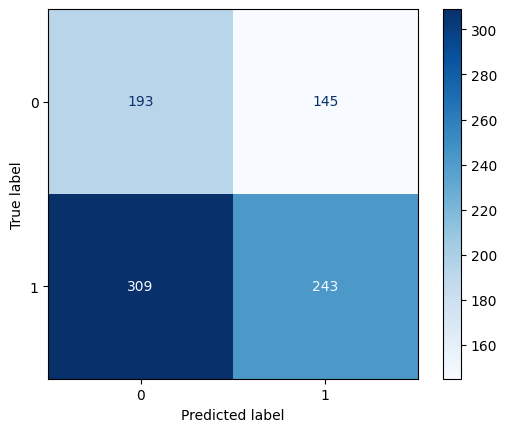


 Classification Report:
              precision    recall  f1-score   support

          no       0.38      0.57      0.46       338
         yes       0.63      0.44      0.52       552

    accuracy                           0.49       890
   macro avg       0.51      0.51      0.49       890
weighted avg       0.53      0.49      0.50       890



In [50]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], lr, lr_param, scoring='f1', cv=5)

In [ ]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], svc, svc_param, scoring='f1', cv=5)

In [ ]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], dtree, dtree_param, scoring='f1', cv=5)

 Esecuzione GridSearchCV...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\franc\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(



 Migliori parametri trovati:
{'criterion': 'gini'}

 Matrice di Confusione:


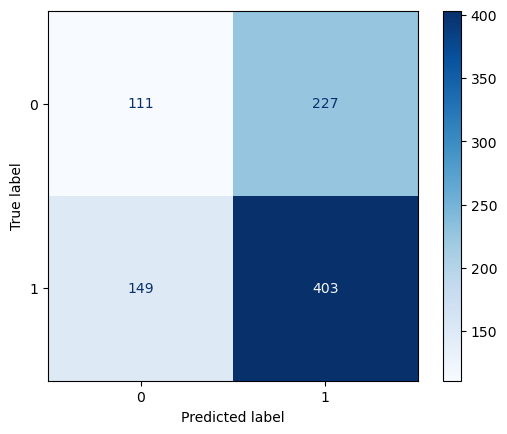


 Classification Report:
              precision    recall  f1-score   support

          no       0.43      0.33      0.37       338
         yes       0.64      0.73      0.68       552

    accuracy                           0.58       890
   macro avg       0.53      0.53      0.53       890
weighted avg       0.56      0.58      0.56       890



In [44]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], rf, rf_param, scoring='f1', cv=5)

 Esecuzione GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\franc\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(



 Migliori parametri trovati:
{'n_neighbors': 1, 'weights': 'uniform'}

 Matrice di Confusione:


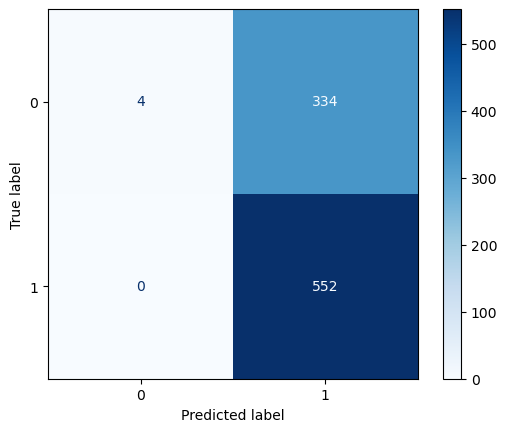


 Classification Report:
              precision    recall  f1-score   support

          no       1.00      0.01      0.02       338
         yes       0.62      1.00      0.77       552

    accuracy                           0.62       890
   macro avg       0.81      0.51      0.40       890
weighted avg       0.77      0.62      0.49       890



In [45]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], kn, kn_param, scoring='f1', cv=5)

In [ ]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], xgb, xgb_param, scoring='f1', cv=5)

#### Long answer

In [52]:
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
Artificial_BoW = vectorizer.fit_transform(df_artificial_sampled["long_answer"])
Labeled_BoW = vectorizer.fit_transform(df_labeled_clean["long_answer"])

In [ ]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], nb, nb_param, scoring='f1', cv=5)

In [ ]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], lr, lr_param, scoring='f1', cv=5)

In [ ]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], svc, svc_param, scoring='f1', cv=5)

In [ ]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], dtree, dtree_param, scoring='f1', cv=5)

In [ ]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], rf, rf_param, scoring='f1', cv=5)

In [ ]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], kn, kn_param, scoring='f1', cv=5)

In [ ]:
train_and_evaluate_model(Artificial_BoW, df_artificial_sampled["final_decision"], Labeled_BoW, df_labeled_clean["final_decision"], xgb, xgb_param, scoring='f1', cv=5)

# Word2vec

### Question + context

In [53]:
model_W2V_qc = Word2Vec(df_artificial_sampled_prep["text"], vector_size=100, window=5, min_count=2, workers=4, sg=1)

In [55]:
import numpy as np
def vectorize(tokens, model, vector_size):
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)



Artificial_W2V_qc = df_artificial_sampled['text'].apply(lambda x: vectorize(x, model_W2V_qc, 100))
Labeled_W2V_qc = df_labeled_clean['text'].apply(lambda x: vectorize(x, model_W2V_qc, 100))

In [ ]:
train_and_evaluate_model(Artificial_W2V_qc, df_artificial_sampled_prep["final_decision"],Labeled_W2V_qc , df_labeled_clean_prep["final_decision"], nb, nb_param, scoring='f1', cv=5)

#### Long answer

In [ ]:
model_W2V_la = Word2Vec(df_artificial_sampled_prep["long_answer"], vector_size=100, window=5, min_count=2, workers=4, sg=1)

In [ ]:
import numpy as np
def vectorize(tokens, model, vector_size):
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)



Artificial_W2C_la = df_artificial_sampled['long_answer'].apply(lambda x: vectorize(x, model_W2V_la, 100))
Labeled_W2V_la = df_labeled_clean['long_answer'].apply(lambda x: vectorize(x, model_W2V_la, 100))

In [ ]:
train_and_evaluate_model(Artificial_W2C_la, df_artificial_sampled_prep["final_decision"],Labeled_W2V_la , df_labeled_clean_prep["final_decision"], nb, nb_param, scoring='f1', cv=5)

<h5>
In tutti e 3 i casi le performance dei classificatori peggiorano rispetto alla precedente analisi fatta con tf-idf.
Word2Vec, pur essendo efficace nel catturare le relazioni semantiche tra parole grazie ai suoi vettori densi appresi in base al contesto, presenta alcune limitazioni nei compiti di classificazione. In particolare, non tiene conto direttamente della frequenza delle parole nei documenti né della loro posizione, se non in modo indiretto attraverso la finestra di contesto. Di conseguenza, quando si rappresenta un documento tramite la media dei vettori delle parole, si perde informazione importante legata alla distribuzione e all'importanza delle parole nel testo. Al contrario, TF-IDF rappresenta ogni documento come un vettore sparso che riflette le frequenze pesate delle parole, enfatizzando quelle rare ma potenzialmente discriminanti per la classificazione, e penalizzando le parole troppo comuni. Mentre Word2Vec è un modello non supervisionato orientato al significato, TF-IDF si rivela spesso più efficace per compiti supervisionati poiché evidenzia direttamente le caratteristiche utili alla distinzione tra classi.
</h5>

## Tf-IDF

#### Question + context

In [70]:
vectorizer_tfidf_qc = TfidfVectorizer(max_df=0.5, min_df=5)
Artificial_tfidf_qc = vectorizer_tfidf_qc.fit_transform(df_artificial_sampled['text'])
Labeled_tfidf_qc = vectorizer_tfidf_qc.transform(df_labeled_clean['text'])  # metto quello non preprocessato perche fa gia lui il preprocessing

In [ ]:
train_and_evaluate_model(Artificial_tfidf_qc, df_artificial_sampled_prep["final_decision"], Labeled_tfidf_qc, df_labeled_clean_prep["final_decision"], nb, nb_param, scoring='f1', cv=5)

## Embedding Techniques: BioBERT + HDBSCAN for Unlabeled Dataset Clustering.

We tried to appy clustering techniques to explore the natural structure of the dataset. As could be expected, this dataset is not particularly suitable for such an approach.

### Pipeline: 
- Use BioBERT to obtain embeddings after merging question+contexts. 
- Apply HDBSCAN to the embeddings to perform clustering on the Unlabeled Dataset.
- Analyze clustering to understand latent groupings in unlabeled biomedical QA data 

In [ ]:
# This is the code to obtain biobert_embeddings.npy

'''from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import os

# Carica tokenizer e modello BioBERT
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model.eval()

# Usa GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Funzione per estrarre embedding CLS
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return cls_embedding.squeeze().cpu().numpy()  # numpy array

# Percorso del file per salvare gli embeddings progressivamente
# Modifica il percorso per salvare su Google Drive
embedding_file = '/content/drive/MyDrive/BioBERT-Google-Colab/biobert_embeddings.npy'


# Se il file esiste già, carica gli embeddings precedenti
if os.path.exists(embedding_file):
    embeddings_array = np.load(embedding_file)
else:
    embeddings_array = []

# Imposta il numero di iterazioni per il salvataggio progressivo
batch_size = 1000  # Salva ogni 1000 embeddings

# Applica a tutto il dataset con tqdm
for i, text in tqdm(enumerate(df_unlabeled['full_text']), total=len(df_unlabeled)):
    emb = get_cls_embedding(text)
    embeddings_array.append(emb)
    
    # Salva ogni 'batch_size' embeddings
    if (i + 1) % batch_size == 0:
        np.save(embedding_file, np.array(embeddings_array))
        print(f"Salvato progressivamente fino all'elemento {i+1}")
    
# Dopo aver completato il ciclo, salva gli embeddings finali
np.save(embedding_file, np.array(embeddings_array))

'''

In [ ]:
import numpy as np
# It is necessary to instert the path to the file in your computer

embeddings_biobert = np.load("biobert_embeddings.npy")
print(embeddings_biobert.shape)

(61249, 768)


# Topic Modeling with LDA

In this section, we explore the latent thematic structure of the dataset using **Latent Dirichlet Allocation (LDA)**, a widely used probabilistic topic modeling algorithm. Our analysis is based on the **TF-IDF representation** of the full preprocessed text, which includes the question, context, and long answer fields. The preprocessing involved lowercasing, lemmatization, and removal of common clinical stopwords to emphasize content-bearing terms.

We first split the **unlabeled dataset** into a training and test set. The LDA model was trained on the training portion using **TF-IDF vectors** as input, even though traditional LDA is typically applied on raw term frequencies. We chose to use TF-IDF to downweight overly common terms while retaining a sparse, interpretable representation.

To determine the number of topics (`n_components`) and training iterations (`max_iter`), we experimented with various combinations and evaluated their impact on model performance using the **perplexity score**. The final configuration was selected based on the **best trade-off between model quality and computational cost**.

After training, we:
- Evaluated model generalization on the **test set**, where the perplexity score provided a quantitative measure of how well the model captured the underlying data distribution.
- **Inspected the top words for each topic**, giving a qualitative insight into the dominant themes identified by the model.
- **Tested topic coherence** by examining the dominant topics assigned to a specific document in the test set, confirming that the topic distribution aligned with the document's content.
- Finally, we generated a **3D t-SNE visualization** of the dominant topics across documents, enabling us to visually assess how well the model clustered documents into coherent topic regions in reduced space.

This approach allowed us to gain an interpretable, unsupervised overview of the main themes within our dataset, even if TF-IDF may slightly distort topic proportions compared to raw counts. Despite this, the results remained meaningful and provided valuable insight into the document collection’s structure.
from sklearn.model_selection import train_test_split


In [66]:
from sklearn.model_selection import train_test_split

vec_fulltext_train, vec_fulltext_test = train_test_split(df_unlabeled['text'], test_size=0.4)
print('No. training docs:', len(vec_fulltext_train))
print('No. testing docs:', len(vec_fulltext_test))

No. training docs: 36749
No. testing docs: 24500


In [67]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorization
vectorizer = CountVectorizer(stop_words='english', min_df=5, max_df=.8)
vector_documents_train = vectorizer.fit_transform(vec_fulltext_train)

# LDA
lda = LatentDirichletAllocation(n_components=20, verbose=1, learning_method='online', max_iter=40, random_state=42)  
lda.fit(vector_documents_train)

# The number of topics (n_components) and iterations (max_iter) were chosen empirically.
# We tested several combinations, observing how perplexity evolved with each setting while also considering computational time.
# The selected configuration reflects the best trade-off between model performance and efficiency.

iteration: 1 of max_iter: 40
iteration: 2 of max_iter: 40
iteration: 3 of max_iter: 40
iteration: 4 of max_iter: 40
iteration: 5 of max_iter: 40
iteration: 6 of max_iter: 40
iteration: 7 of max_iter: 40
iteration: 8 of max_iter: 40
iteration: 9 of max_iter: 40
iteration: 10 of max_iter: 40
iteration: 11 of max_iter: 40
iteration: 12 of max_iter: 40
iteration: 13 of max_iter: 40
iteration: 14 of max_iter: 40
iteration: 15 of max_iter: 40
iteration: 16 of max_iter: 40
iteration: 17 of max_iter: 40
iteration: 18 of max_iter: 40
iteration: 19 of max_iter: 40
iteration: 20 of max_iter: 40
iteration: 21 of max_iter: 40
iteration: 22 of max_iter: 40
iteration: 23 of max_iter: 40
iteration: 24 of max_iter: 40
iteration: 25 of max_iter: 40
iteration: 26 of max_iter: 40
iteration: 27 of max_iter: 40
iteration: 28 of max_iter: 40
iteration: 29 of max_iter: 40
iteration: 30 of max_iter: 40
iteration: 31 of max_iter: 40
iteration: 32 of max_iter: 40
iteration: 33 of max_iter: 40
iteration: 34 of ma

LatentDirichletAllocation(learning_method='online', max_iter=40,
                          n_components=20, random_state=42, verbose=1)

In [ ]:
# Performance evaluation of topic modeling on the test set

vector_documents_test = vectorizer.transform(vec_fulltext_test)
perplexity_fulltext = lda.perplexity(vector_documents_test)
print(f"The Perplexity of the lda model is: ", {str(lda.perplexity(vector_documents_test))})

# The perplexity score of the LDA model on the test set is approximately 2338.
# Perplexity measures how well the model predicts a sample; lower values indicate better generalization.
# However, perplexity is not always aligned with human interpretability of topics and can be difficult to assess directly.
# A relatively high perplexity (as observed here) may indicate that the model struggles to capture coherent topic structures,
# especially when using TF-IDF vectors instead of raw term frequencies, which can distort the true word distributions.

The Perplexity of the lda model is:  {'2902.271590603901'}


In [ ]:
vocab = vectorizer.get_feature_names_out()

# Print the most important words for each topic
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    top_words = [vocab[idx] for idx in sorted_terms[:10]]
    concatenated_terms = '[' + ', '.join(top_words) + ']'
    print(f'Topic {i + 1}:\t{concatenated_terms}')

In [ ]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Here we test a document in the test set to see if the topic assigned are coherent with the document's content

doc_example = vec_fulltext_test.iloc[1]
print(doc_example)

In [ ]:
doc_vec_example = vectorizer.transform([doc_example])[0]
topic_vec = lda.transform(doc_vec_example)[0]

In [ ]:
sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

In [ ]:
for i in range(10):
    if sorted_prevalence[i] < .01: break
    topic = sorted_topics[i]
    sorted_terms = np.flip(lda.components_[topic].argsort())
    print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

In [ ]:
from sklearn.manifold import TSNE

# TSNE transformation on the test set
tsne_embedding_test = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_test))

# TSNE transformation on the train set
tsne_embedding_train = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_train))

# Check of data shape
print(tsne_embedding_test.shape)
print(tsne_embedding_train.shape)


In [ ]:
[x_test, y_test, z_test] = np.transpose(tsne_embedding_test)
[x_train, y_train, z_train] = np.transpose(tsne_embedding_train)

In [ ]:
# Transform the documents into their topic distribution format

topic_distributions_test = lda.transform(vector_documents_test)
topic_distributions_train = lda.transform(vector_documents_train)

# Now `topic_distributions` is a matrix of shape (num_documents, num_topics),
# where each row represents a document and each column contains the probability of that topic in the document

In [ ]:
# Get the topic with the highest probability for each document

dominant_topics_train = topic_distributions_train.argmax(axis=1)
dominant_topics_test = topic_distributions_test.argmax(axis=1)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Crea la figura
fig = plt.figure(figsize=(18, 10))

# Plot per il training set
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_train, y_train, z_train,
            c=dominant_topics_train)
ax1.set_title("Training Set - Dominant Topics")
ax1.set_xlabel("Comp 1")
ax1.set_ylabel("Comp 2")
ax1.set_zlabel("Comp 3")

# Plot per il test set
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x_test, y_test, z_test, 
            c=dominant_topics_test)
ax2.set_title("Test Set - Dominant Topics")
ax2.set_xlabel("Comp 1")
ax2.set_ylabel("Comp 2")
ax2.set_zlabel("Comp 3")


plt.tight_layout()
plt.show()


### Clustering with HDBSCAN

In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Riduci la dimensionalità degli embedding
# tsne = TSNE(n_components=2, random_state=42)
# embeddings_2d = tsne.fit_transform(embeddings_biobert)

# # Visualizza i risultati
# plt.figure(figsize=(10, 8))
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
# plt.title('t-SNE visualization of BioBERT embeddings')
# plt.show()

c:\Users\ASUS\Desktop\Progetto\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS\Desktop\Progetto\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


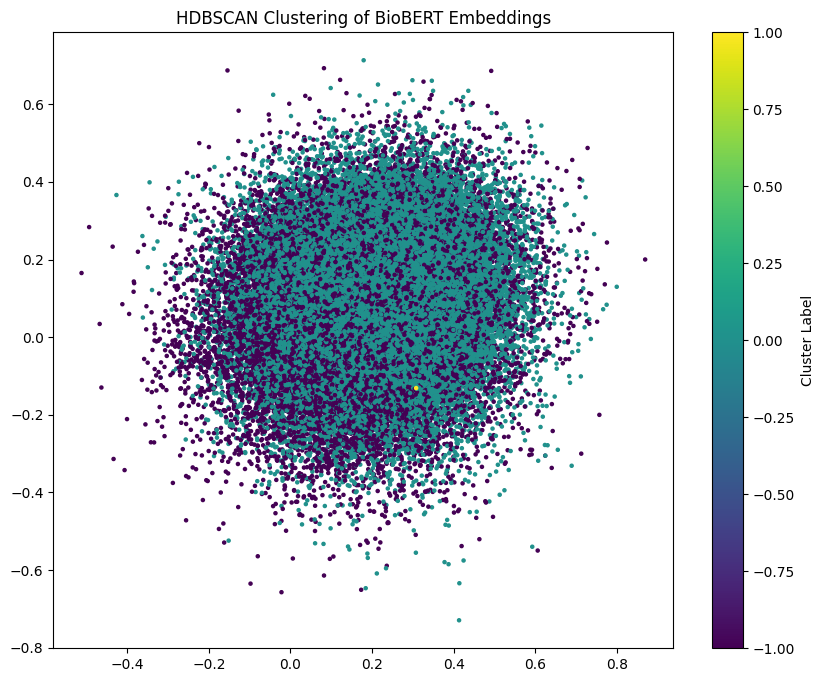

In [ ]:
from hdbscan import HDBSCAN

# Crea e addestra il modello HDBSCAN
clusterer = HDBSCAN(min_cluster_size=5)
cluster_labels_biobert = clusterer.fit_predict(embeddings_biobert)

# Visualizza i cluster
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_biobert[:, 0], embeddings_biobert[:, 1], c=cluster_labels_biobert, cmap='viridis', s=5)
plt.title('HDBSCAN Clustering of BioBERT Embeddings')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
# Adding the label to the main dataframe
df_unlabeled['cluster_biobert'] = cluster_labels_biobert

In [ ]:
import numpy as np

# This excludes the outliers 
n_clusters = len(set(cluster_labels_biobert)) - (1 if -1 in cluster_labels_biobert else 0)
print(f"Number of clusters in total (excluding outliers): {n_clusters}")

Number of clusters in total (excluding outliers): 3148


In [ ]:
noise_ratio = np.sum(cluster_labels_biobert == -1) / len(cluster_labels_biobert)
print(f"Percentuale di noise: {noise_ratio:.2%}")

Percentuale di noise: 35.83%


In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

# Filters only NON noise points (label != -1)
mask = cluster_labels_biobert != -1
filtered_embeddings = embeddings_biobert[mask]
filtered_labels = cluster_labels_biobert[mask]

# Calculates number of real clusters (excluding -1)
n_clusters = len(set(filtered_labels))


score = silhouette_score(filtered_embeddings, filtered_labels)
print(f"Silhouette Score (without outliers): {score:.4f}")

Silhouette Score (senza outlier): 0.0084


### Clustering with HDBSCAN

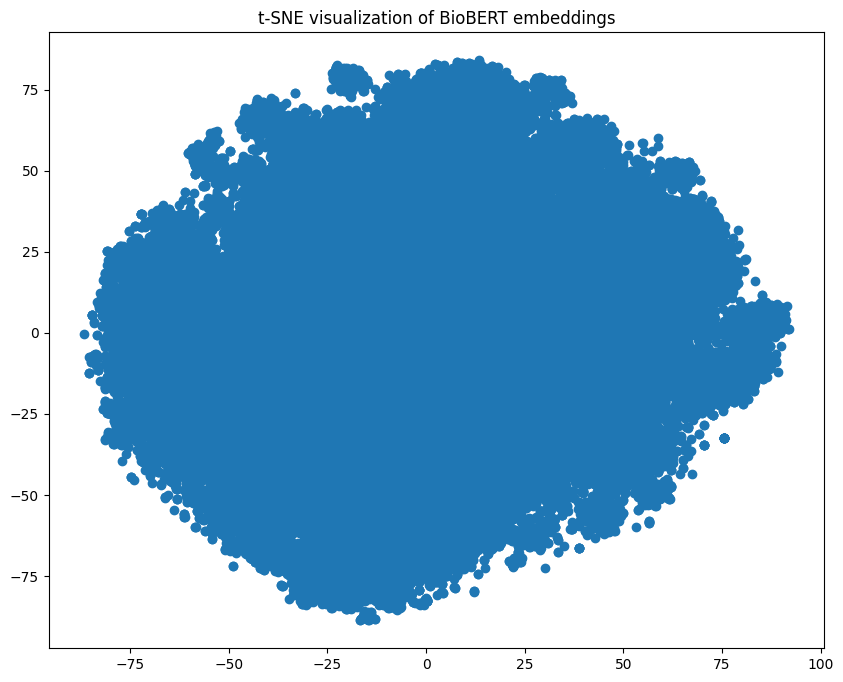

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Riduci la dimensionalità degli embedding
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_biobert)

# Visualizza i risultati
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title('t-SNE visualization of BioBERT embeddings')
plt.show()


C:\Users\213053\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\213053\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


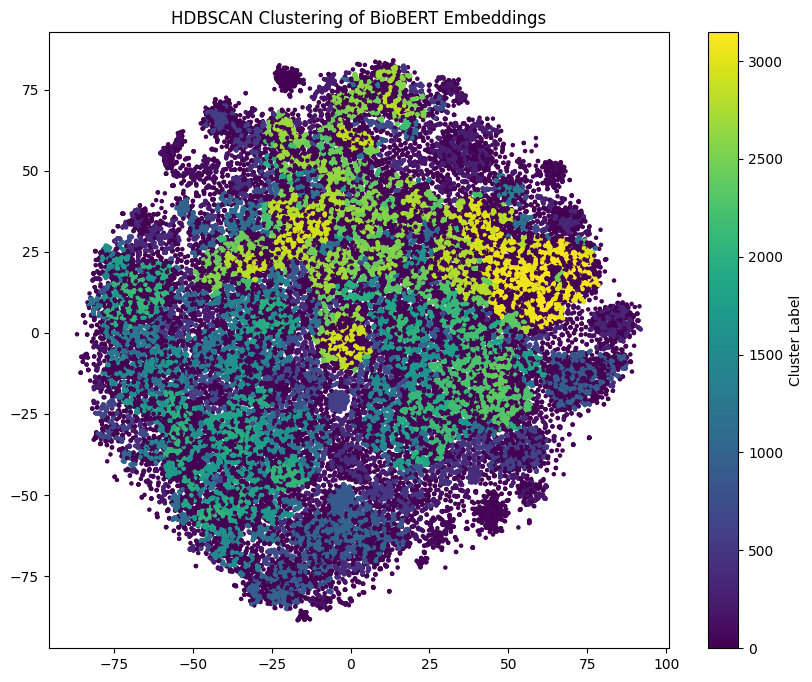

In [ ]:
from hdbscan import HDBSCAN

# Crea e addestra il modello HDBSCAN
clusterer = HDBSCAN(min_cluster_size=5)
cluster_labels_biobert = clusterer.fit_predict(embeddings_2d)

# Visualizza i cluster
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels_biobert, cmap='viridis', s=5)
plt.title('HDBSCAN Clustering of BioBERT Embeddings')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
# Adding the label to the main dataframe
df_unlabeled['cluster_biobert'] = cluster_labels_biobert

In [ ]:
import numpy as np

# This excludes the outliers 
n_clusters = len(set(cluster_labels_biobert)) - (1 if -1 in cluster_labels_biobert else 0)
print(f"Number of clusters in total (excluding outliers): {n_clusters}")

Number of clusters in total (excluding outliers): 3148


In [ ]:
noise_ratio = np.sum(cluster_labels_biobert == -1) / len(cluster_labels_biobert)
print(f"Percentuale di noise: {noise_ratio:.2%}")

Percentuale di noise: 35.83%


In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

# Filters only NON noise points (label != -1)
mask = cluster_labels_biobert != -1
filtered_embeddings = embeddings_biobert[mask]
filtered_labels = cluster_labels_biobert[mask]

# Calculates number of real clusters (excluding -1)
n_clusters = len(set(filtered_labels))


score = silhouette_score(filtered_embeddings, filtered_labels)
print(f"Silhouette Score (without outliers): {score:.4f}")

Silhouette Score (senza outlier): 0.0084


## Named Entity Recognition (NER) and BioBERT Fine-Tuning

Named Entity Recognition (NER) is a Natural Language Processing (NLP) task that involves identifying and classifying key information (entities) in text into predefined categories such as people, locations, organizations, or—in the biomedical context—diseases, chemicals, and genes. In our project, we use NER to automatically extract relevant biomedical entities from unstructured text. This is a crucial step for downstream tasks such as document classification, clustering, and knowledge extraction.

To improve the performance of entity recognition on biomedical data, we fine-tuned the [BioBERT](https://github.com/dmis-lab/biobert) model, a domain-specific language representation model pre-trained on large-scale biomedical corpora.

### Fine-Tuning on Google Colab
To speed up the computational process and make the pipeline more accessible to other users, we chose to perform the fine-tuning on Google Colab. You can find our Colab notebook at the following link:

🔗 [Fine-Tuning BioBERT on Google Colab](https://colab.research.google.com/drive/1fEpiZbmUZJWfDV2dpQjRw81nPtgeh2lm?usp=sharing)

### Dataset Selection
To select the most suitable dataset for fine-tuning, we referred to the official [BioBERT GitHub repository](https://github.com/dmis-lab/biobert-pytorch/tree/master/named-entity-recognition), which includes several benchmark biomedical NER datasets. Based on the coverage and reported performance in the paper by [Lee et al., 2019](https://doi.org/10.1093/bioinformatics/btz682), we selected the BC5CDR dataset.

This dataset is particularly well-suited to our goals, as it contains annotations for both chemical substances (e.g., drugs) and diseases, enabling a more comprehensive evaluation and application of the fine-tuned model in biomedical text analysis.